In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

import cv2
from PIL import Image
from torchvision import transforms

from einops import rearrange
from vision_transformer_pytorch import VisionTransformer

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((384,384)),transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [3]:
from PretrainedModel.pytorch_pretrained_vit.model import *
model = ViT('B_16_imagenet1k', pretrained=True)
model.eval()

Loaded pretrained weights.


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

In [4]:
def get_attention_map(im, get_mask=False):
    a,b,c=im.shape
    x=transform(im)
    x=rearrange(x,'(h k) w d -> k h w d',k=1)
    logits, att_mat = model(x)
    att_mat = torch.stack(att_mat).squeeze(1)
    #print(att_mat.size())
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=0)
    #print(att_mat.size())
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    #print(v.size())
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    #print(v[0,1:].size())
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    #print(mask.size)
    #mask = cv2.resize(mask / mask.max(), im.size)
    mask=mask/mask.max()
    mask=cv2.resize(mask,(b,a),interpolation=cv2.INTER_AREA)
    mas=np.empty((a,b,c))
    for i in range(c):
        mas[:,:,i]=mask
    result = (mas*im).astype("uint8")
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

In [5]:
image=cv2.imread("img2.png")

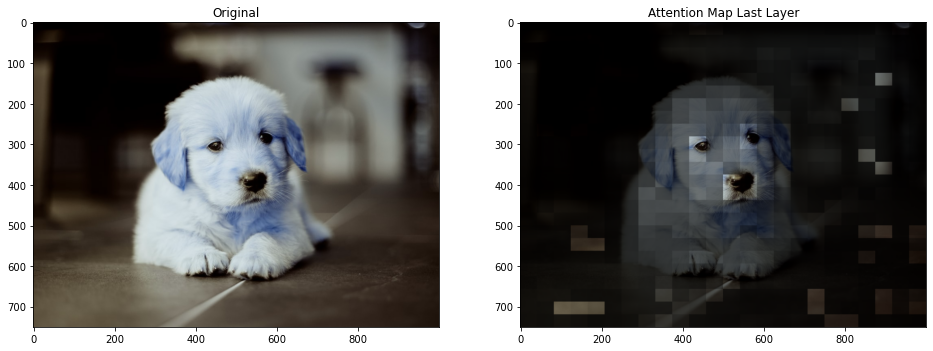

In [6]:
result=get_attention_map(image)
plot_attention_map(image,result)